<a href="https://colab.research.google.com/github/RiviereKevin/Credit-Risk-Analysis/blob/main/AIforFinance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex
import re
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment',  None)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_loan = pd.read_csv("/content/drive/MyDrive/loan.csv")
df_loan.head(5)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (19,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_loan.drop(df_loan.columns.difference(['loan_amnt','term','int_rate','installment','grade','emp_length','home_ownership', 'annual_inc','verification_status','loan_status','purpose',]), 1, inplace=True)

df_loan.isnull().sum()
df_loan.info()
df_loan.annual_inc = df_loan.annual_inc.fillna(0)
df_loan.isnull().sum()

df_loan.drop
df_loan.head(3)

<ipython-input-7-5399e3befffb>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_loan.drop(df_loan.columns.difference(['loan_amnt','term','int_rate','installment','grade','emp_length','home_ownership', 'annual_inc','verification_status','loan_status','purpose',]), 1, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            887379 non-null  float64
 1   term                 887379 non-null  object 
 2   int_rate             887379 non-null  float64
 3   installment          887379 non-null  float64
 4   grade                887379 non-null  object 
 5   emp_length           842554 non-null  object 
 6   home_ownership       887379 non-null  object 
 7   annual_inc           887375 non-null  float64
 8   verification_status  887379 non-null  object 
 9   loan_status          887379 non-null  object 
 10  purpose              887379 non-null  object 
dtypes: float64(4), object(7)
memory usage: 74.5+ MB


,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose
0,5000.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card
1,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,car
2,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business


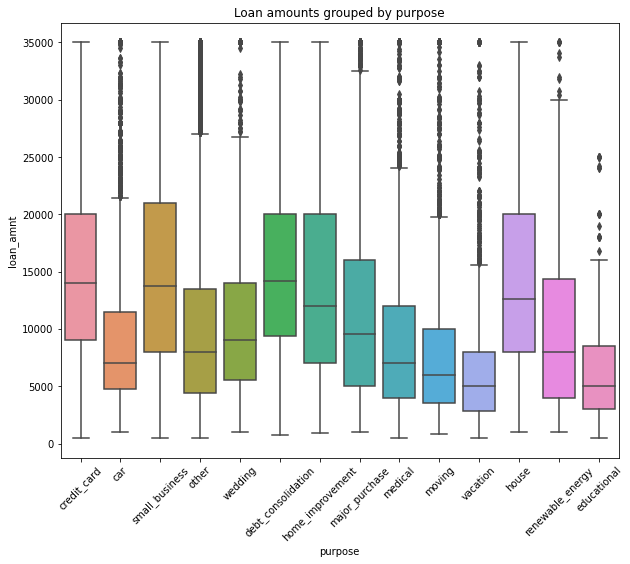

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(x='purpose', y='loan_amnt', data=df_loan)
plt.xticks(rotation=45)
plt.title('Loan amounts grouped by purpose')
plt.show()


**Interpretation :  Credit card,  business, debt consolidation, home improvement, and buying a house got highest amount**

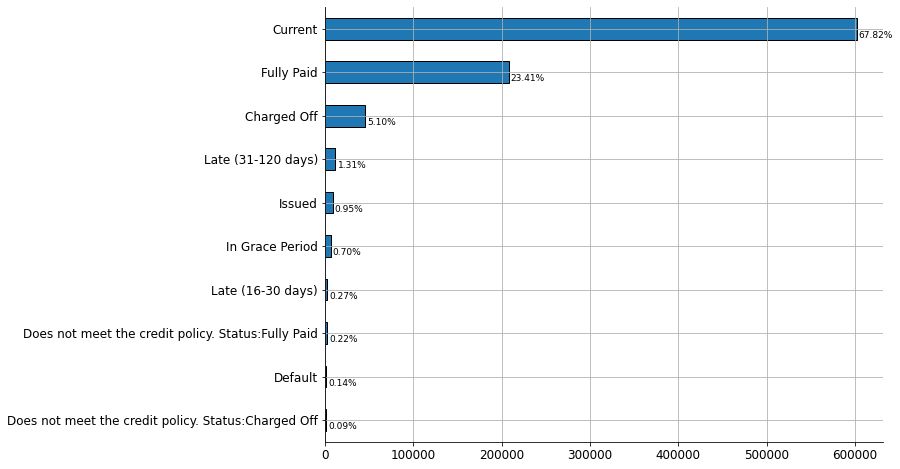

In [ ]:
plt.figure(figsize=(10,8))

ax = df_loan['loan_status'].value_counts().sort_values().plot.barh(edgecolor='black', grid=True, fontsize=12)

for p in ax.patches:
    width = p.get_width()
    ax.text(width+2500, p.get_y(), '{:.2%}'.format(width/len(df_loan)), ha='left', va='bottom', fontsize=9)

sns.despine()    

Based on the sample

In [ ]:
label_bin = [
    (0, ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid', 'Current']),
    (1, ['Late (31-120 days)', 'Late (16-30 days)', 'In Grace Period', 
         'Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off'])
]

# function to apply the transformation
def classify_label(text):
    for category, matches in label_bin:
        if any(match in text for match in matches):
            return category
    return None

df_loan.loc[:, 'label'] = df_loan['loan_status'].apply(classify_label)
df_loan = df_loan.drop('loan_status', axis=1)

def SC_LabelEncoder1(text):
    if text == "E":
        return 1
    elif text == "D":
        return 2
    elif text == "C":
        return 3
    elif text == "B":
        return 4
    elif text == "A":
        return 5
    else:
        return 0
    
    
def SC_LabelEncoder2(text):
    if text == "< 1 year":
        return 1
    elif text == "1 year":
        return 2
    elif text == "2 years":
        return 3
    elif text == "3 years":
        return 4
    elif text == "4 years":
        return 5
    elif text == "5 years":
        return 6
    elif text == "6 years":
        return 7
    elif text == "7 years":
        return 8
    elif text == "8 years":
        return 9
    elif text == "9 years":
        return 10
    elif text == "10 years":
        return 11
    elif text == "10+ years":
        return 12
    else:
        return 0

def SC_LabelEncoder3(text):
    if text == "RENT":
        return 1
    elif text == "MORTGAGE":
        return 2
    elif text == "OWN":
        return 3
    else:
        return 0
    
df_loan["grade"] = df_loan["grade"].apply(SC_LabelEncoder1)
df_loan["emp_length"] = df_loan["emp_length"].apply(SC_LabelEncoder2)
df_loan["home_ownership"] = df_loan["home_ownership"].apply(SC_LabelEncoder3)

df_loan.info()

df_loan.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            887379 non-null  float64
 1   term                 887379 non-null  object 
 2   int_rate             887379 non-null  float64
 3   installment          887379 non-null  float64
 4   grade                887379 non-null  int64  
 5   emp_length           887379 non-null  int64  
 6   home_ownership       887379 non-null  int64  
 7   annual_inc           887379 non-null  float64
 8   verification_status  887379 non-null  object 
 9   purpose              887379 non-null  object 
 10  label                878919 non-null  float64
dtypes: float64(5), int64(3), object(3)
memory usage: 74.5+ MB


,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,label
0,5000.0,36 months,10.65,162.87,4,12,1,24000.0,Verified,credit_card,0.0
1,2500.0,60 months,15.27,59.83,3,1,1,30000.0,Source Verified,car,1.0
2,2400.0,36 months,15.96,84.33,3,12,1,12252.0,Not Verified,small_business,0.0
3,10000.0,36 months,13.49,339.31,3,12,1,49200.0,Source Verified,other,0.0
4,3000.0,60 months,12.69,67.79,4,2,1,80000.0,Source Verified,other,0.0


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
# Number of 1 & 0 ################################
num_zeros = (df_loan['label'] == 0).sum()
print("Number of zeros in column label:", num_zeros)
num_of_1 = (df_loan['label'] == 1).sum()
print("Number of 1 in column label:", num_of_1)

print("Result of 1:\n ({:.2f}% of total)\n ".format(num_of_1/num_zeros * 100))
########################################################
df_loan['term'] = df_loan['term'].astype(str)
df_loan['term'] = df_loan['term'].str.replace(' months', '').astype(int)


Number of zeros in column label: 811490
Number of 1 in column label: 67429
Result of 1:
 (8.31% of total)
 


In [ ]:
#@title Head toward Logistic Regression :
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

for col in ["verification_status", "purpose","term"]:
    le = LabelEncoder()
    le.fit(df_loan[col])
    df_loan[col] = le.transform(df_loan[col])
df_loan.head()

df_loan.isnull().sum()
df_loan.label = df_loan.label.fillna(1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
columns = ['loan_amnt','term','int_rate','installment','grade','emp_length','home_ownership', 'annual_inc','verification_status', 'purpose']
lr.fit(df_loan[columns], df_loan["label"])

LogisticRegression()

In [ ]:
# split train test set
train, test = train_test_split(df_loan, test_size=0.2, stratify=df_loan['label'], random_state=1)

y_train = train.pop('label')
y_test = test.pop('label')
X_train = train
X_test = test

(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((709903, 10), (709903,)), ((177476, 10), (177476,)))

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
logreg = LogisticRegression().fit(X_train, y_train)

In [ ]:
# make predictions on the test data
y_pred_probs = logreg.predict_proba(X_test)

In [ ]:
threshold = 0.22

In [ ]:
y_pred = (y_pred_probs[:, 1] > threshold).astype(int)

In [ ]:
cm = confusion_matrix(y_test, y_pred)

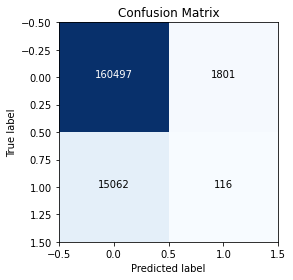

In [ ]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# add the text annotations
threshold = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > threshold else 'black')

plt.tight_layout()
plt.show()

In [ ]:
#@title Receiver Operating Characteristic - ROC & TPR/FPR



*   Precision = TP/(TP+FP)
*   Recall = TP/(TP+FN)
*   TPR = TP/(TP+FN) 
*   FPR = FP/(FP+TN)




In [ ]:
precision_1 = round((160497/(160497+1801)),1)
Recall_1 = round((160497/(160497+15062)),1)
TPR = round((160497/(160497+15062)),1)
FPR = round((1801/(1801+116)),1)
print(precision_1, Recall_1, TPR, FPR)

1.0 0.9 0.9 0.9


Good prediction on positive rate, however bad prediction on false prediction rate. The model struggle to detect false rate

# Scores & Accuracy

In [ ]:
print('Accuracy of logistic regression on train set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of logistic regression on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


Accuracy of logistic regression on train set: 0.91
Accuracy of logistic regression on test set: 0.91
